In [5]:
import json 
import os.path
from simulation import Simulation
from simulation.SimpleModeSimulation import SimpleModeSimulation
import matplotlib.pyplot as plt
import numpy as np

FIRST_BLOCK_HEIGHT_DURING_CONGESTION = 498084
FIRST_BLOCK_NO_CONGESTION = 716644

MEMPOOL_DIR_DURING_CONGESTION = "../mempool-during-congestion"
MEMPOOL_DIR_NO_CONGESTION = "../mempool-no-congestion"

# Edges crossed by the Max-Cut (LMC), computed with the unweighted imbalanced-max-cut Greedy procedure, 
# with data obtained on May 5, 2022
MAX_CUT_SIZE = 63251 

# We read the JSON file containing blocks data (height, number of transactions)

blocks_file = open("../blocks/blocks.json", mode = 'r')
blocks_data_content = blocks_file.read()
blocks_data = json.loads(blocks_data_content)

# We read the file containing mempool historical data

FIRST_BLOCK_HEIGHT = FIRST_BLOCK_HEIGHT_DURING_CONGESTION
MEMPOOL_DIR = MEMPOOL_DIR_DURING_CONGESTION

# FIRST_BLOCK_HEIGHT = FIRST_BLOCK_NO_CONGESTION
# MEMPOOL_DIR = MEMPOOL_DIR_NO_CONGESTION

i = 1
mempool_data_json_string = ''

while os.path.exists(f"{MEMPOOL_DIR}/{i}_mempool"):
    mempool_data_file = open(f"{MEMPOOL_DIR}/{i}_mempool", mode = 'r')
    mempool_data_content = mempool_data_file.read()
    
    # We replace call() from file content (it is used for the website to load the JSONP)
    mempool_data_content = mempool_data_content[5 : len(mempool_data_content) - 2]
    
    # We remove the first and the last square brackets, then I will add them again at the end before parsing the JSON,
    # in order to obtain a single merged json of all the mempool data
    mempool_data_content = mempool_data_content[1:]
    mempool_data_content = mempool_data_content[:-1]

    mempool_data_content += ','

    mempool_data_json_string += mempool_data_content
    mempool_data_file.close()

    i += 1

mempool_data_json_string = mempool_data_json_string[:-1]
mempool_data_json_string = f"[{mempool_data_json_string}]"

# Parsing JSON file

mempool_data = json.loads(mempool_data_json_string) 

In [3]:
PROBLEMATIC_INTERVALS = [[1516728783, 1516729440], [1515943500, 1515944160]] 

def get_median_index_fee(first_snapshot):

    initial_tx_count_per_fee_level = first_snapshot[1]
    initial_tx_count_per_fee_level = initial_tx_count_per_fee_level[1:]
    total_tx_count = sum(initial_tx_count_per_fee_level)

    # Computing the index of the median fee in `fee_ranges` (in the first snapshot of the simulation)

    acc = 0
    i = 0
    median_index = 0

    for c in initial_tx_count_per_fee_level:
        acc = acc + c
        if acc >= total_tx_count / 2:
            # As soon as we detected that half of all the txs in the mempool have a lower fee 
            # than the current fee index (and half have an higher fee), than this is the median fee index
            median_index = i
            break
        else:
            i = i + 1  

    return median_index    
       
def get_average_index_fee(first_snapshot): 

    initial_tx_count_per_fee_level = first_snapshot[1]
    initial_tx_count_per_fee_level = initial_tx_count_per_fee_level[1:]
    total_tx_count = sum(initial_tx_count_per_fee_level)

    # Computing the index of the average fee in `fee_ranges` (in the first snapshot of the simulation)

    acc = 0
    i = 0

    while(i < len(initial_tx_count_per_fee_level)):
        acc = acc + (Simulation.fee_ranges[i] * initial_tx_count_per_fee_level[i])
        i = i + 1

    avg_fee = acc / total_tx_count
    average_index = find_index_of_fee_in_ranges(avg_fee)

    return average_index  

def find_index_of_fee_in_ranges(fee):
    fee_index = 0
    i = 1

    while i < len(Simulation.fee_ranges):
        if Simulation.fee_ranges[i-1] <= fee and fee < Simulation.fee_ranges[i]:
            fee_index = i-1
            return fee_index
        i = i + 1

    return len(Simulation.fee_ranges) - 1 # maximum fee index


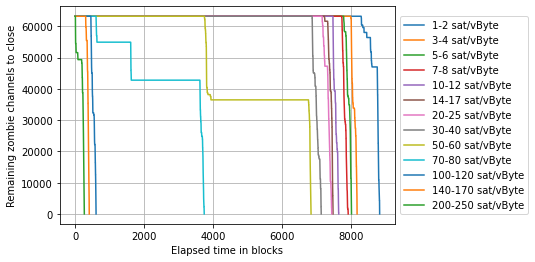

In [4]:
fig, ax = plt.subplots()
ax.grid(True) 

fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]
fee_indexes = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]

plot_blocks_array = []
plot_remaining_zombie_channels_array = []
labels = []

attacked_fraction_of_max_cut = {
    "k" : 30,
    "edges" : 26729
}

initial_num_zombie_channels = MAX_CUT_SIZE
#initial_num_zombie_channels = attacked_fraction_of_max_cut["edges"]

for fee_index in fee_indexes:
    sim = SimpleModeSimulation(mempoolData=mempool_data, blocksData=blocks_data, isDynamic=False, firstBlockHeightOfSimulation=FIRST_BLOCK_HEIGHT, problematicIntervals=PROBLEMATIC_INTERVALS, step=-1, beta=-1, remainingTxs=initial_num_zombie_channels, feeIndexInRanges=fee_index)
    needed_blocks, plot_remaining_zombie_channels = sim.run()
    #plot_blocks_array.append(plot_blocks)
    plot_remaining_zombie_channels_array.append(plot_remaining_zombie_channels)
    #plt.plot(plot_blocks, plot_remaining_zombie_channels)
    plt.plot(plot_remaining_zombie_channels)
    labels.append(f"{fee_ranges[fee_index]}-{fee_ranges[fee_index + 1]} sat/vByte")

plt.xlabel('Elapsed time in blocks') 
plt.ylabel(f'Remaining zombie channels to close')
plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()